# Lesson 5 - EfficientNet and Custom Pretrained Models

## Lesson Video:

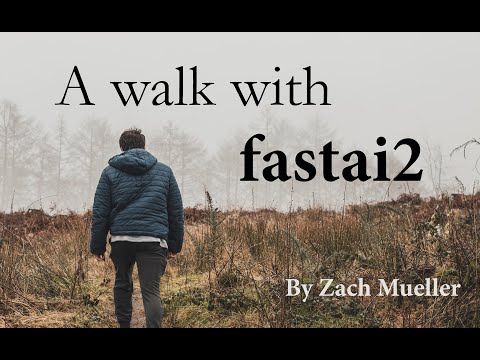

In [ ]:
#hide_input
from IPython.lib.display import YouTubeVideo
from datetime import timedelta
start = int(timedelta(minutes=36, seconds=43).total_seconds())
YouTubeVideo('4w3sEgqDvSo', start=start)

In [ ]:
#hide
#Run once per session
!pip install fastai wwf timm -q --upgrade

In [ ]:
#hide_input
from wwf.utils import state_versions
state_versions(['fastai', 'fastcore', 'wwf', 'timm'])


---
This article is also a Jupyter Notebook available to be run from the top down. There
will be code snippets that you can then run in any environment.

Below are the versions of `fastai`, `fastcore`, `wwf`, and `timm` currently running at the time of writing this:
* `fastai`: 2.1.10 
* `fastcore`: 1.3.13 
* `wwf`: 0.0.7 
* `timm`: 0.3.2 
---

This notebook will cover:
* Using a `PyTorch` model
* Using pre-trained weights for transfer learning
* Setting up a `cnn_learner` style `Learner`

## The Problem:

The problem today will be a familiar one, `PETs`, as we are going to focus on the `Learner` instead

In [ ]:
from fastai.vision.all import *
from fastai.vision.learner import _update_first_layer

Below you will find the exact imports for everything we use today

In [ ]:
from fastcore.xtras import Path

from fastai.callback.hook import summary
from fastai.callback.progress import ProgressCallback
from fastai.callback.schedule import lr_find, fit_one_cycle

from fastai.data.block import DataBlock, CategoryBlock
from fastai.data.core import Datasets
from fastai.data.external import untar_data, URLs
from fastai.data.transforms import get_image_files, Normalize, RandomSplitter, GrandparentSplitter, RegexLabeller, ToTensor, IntToFloatTensor, Categorize, parent_label

from fastai.learner import Learner
from fastai.losses import LabelSmoothingCrossEntropy
from fastai.metrics import error_rate, accuracy

from fastai.vision.augment import aug_transforms, RandomResizedCrop, Resize, FlipItem
from fastai.vision.core import PILImage, imagenet_stats
from fastai.vision.data import ImageBlock
from fastai.vision.learner import cnn_learner, create_head, create_body, num_features_model, default_split, has_pool_type, apply_init, _update_first_layer

import torch
from torch import nn
from torchvision.models.resnet import resnet18

from timm import create_model

Let's make our usual dataloaders real quick

In [ ]:
path = untar_data(URLs.PETS)/'images'
fnames = get_image_files(path)
pat = r'/([^/]+)_\d+.*'

In [ ]:
batch_tfms = [*aug_transforms(size=224, max_warp=0), Normalize.from_stats(*imagenet_stats)]
item_tfms = RandomResizedCrop(460, min_scale=0.75, ratio=(1.,1.))
bs=64

In [ ]:
pets = DataBlock(blocks=(ImageBlock, CategoryBlock),
                 get_items=get_image_files,
                 splitter=RandomSplitter(),
                 get_y=RegexLabeller(pat = r'/([^/]+)_\d+.*'),
                 item_tfms=item_tfms,
                 batch_tfms=batch_tfms)

In [ ]:
dls = pets.dataloaders(path, bs=bs)

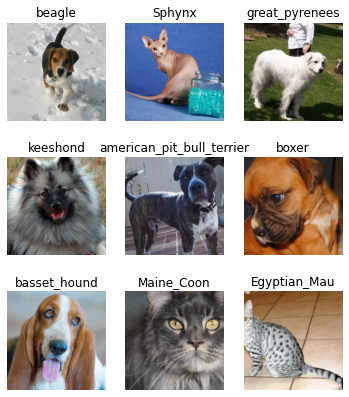

In [ ]:
dls.show_batch(max_n=9, figsize=(6,7))

Now let's focus on our `EfficentNet` model. We'll be working out of Ross Wightman's repository [here](https://github.com/rwightman/pytorch-image-models). Included in this repository is tons of pretrained models for almost every major model in Computer Vision. All were for 224x224 training and validation size. Let's install it

In [ ]:
!pip install timm

Now we can then use his weights one of two ways. First we'll show the direct way to load it in, then we'll load in the weights ourselves

In [ ]:
from timm import create_model

In [ ]:
net = create_model('efficientnet_b3a', pretrained=True)

Now let's take a look at our downloaded model, so we know how to modify it for transfer learning. With fastai models we can do something like so:

In [ ]:
learn = cnn_learner(dls, resnet18)

In [ ]:
learn.model[-1]

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): full: False
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=1024, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=37, bias=False)
)

And we see this head of our model! Let's see if we can do this for our `EfficientNet`

In [ ]:
net[-1]

TypeError: ignored

No! Why?

In [ ]:
len(learn.model)

2

In [ ]:
len(net)

TypeError: ignored

We can see that our `fastai` model was **split** into two different layer groups:

* Group 1: Our encoder, which is everything but the last layer of our original model
* Group 2: Our head, which is a `fastai` version of a `Linear` layer plus a few extra bits

In [ ]:
create_head(2048, 10)

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten(full=False)
  (2): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=2048, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=10, bias=False)
)

How do we do this for our model? Let's take a look at it:

In [ ]:
net

EfficientNet(
  (conv_stem): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): SiLU(inplace=True)
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
        (bn1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SiLU(inplace=True)
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
        )
        (conv_pw): Conv2d(40, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act2): Identity()
      )
      (1): DepthwiseS

We can see that our `Pooling` layer and our `Linear` layer is the last two layers of our model. Let's pop those off

Now if we use the original `fastai` `create_body` function, we'll get an error:

In [ ]:
body = create_body(net, pretrained=False, cut=-1)

TypeError: ignored

Why? Let's take a look

In [ ]:
def create_body(arch, pretrained=True, cut=None):
    "Cut off the body of a typically pretrained `arch` as determined by `cut`"
    model = arch(pretrained=pretrained)
    #cut = ifnone(cut, cnn_config(arch)['cut'])
    if cut is None:
        ll = list(enumerate(model.children()))
        cut = next(i for i,o in reversed(ll) if has_pool_type(o))
    if   isinstance(cut, int): return nn.Sequential(*list(model.children())[:cut])
    elif callable(cut): return cut(model)
    else: raise NamedError("cut must be either integer or a function")

We can see that arch needs to be a **generator**. Let's try to make a function to help us with specifically his library

In [ ]:
def create_timm_body(arch:str, pretrained=True, cut=None, n_in=3):
    "Creates a body from any model in the `timm` library."
    model = create_model(arch, pretrained=pretrained, num_classes=0, global_pool='')
    _update_first_layer(model, n_in, pretrained)
    if cut is None:
        ll = list(enumerate(model.children()))
        cut = next(i for i,o in reversed(ll) if has_pool_type(o))
    if isinstance(cut, int): return nn.Sequential(*list(model.children())[:cut])
    elif callable(cut): return cut(model)
    else: raise NamedError("cut must be either integer or function")

Let's try it out!

In [ ]:
body = create_timm_body('efficientnet_b3a', pretrained=True)

In [ ]:
len(body)

7

Now we can see that we have seven seperate groups

In [ ]:
body

Sequential(
  (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): SiLU(inplace=True)
  (3): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
        (bn1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SiLU(inplace=True)
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
        )
        (conv_pw): Conv2d(40, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act2): Identity()
      )
      (1): DepthwiseSeparableConv(
      

But we've popped off the last layers we need! Let's move onto our head of the model. We know the input should be `3072` (we can see this in the last linear layer of the original model). We need it 2x it because of our `AdaptiveConcatPooling` We want it to have an output to our classes. But what if we dont' know that?

In [ ]:
nf = num_features_model(nn.Sequential(*body.children())); nf

3072

In [ ]:
head = create_head(nf, dls.c)

In [ ]:
head

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten(full=False)
  (2): BatchNorm1d(3072, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=3072, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=37, bias=False)
)

Now finally we need to wrap it together

In [ ]:
model = nn.Sequential(body, head)

And then we initialize our new head of our model

In [ ]:
apply_init(model[1], nn.init.kaiming_normal_)

Now we have our two layer-long model! What's next?

In [ ]:
len(model)

2

Let's try making a `Learner`

In [ ]:
learn = Learner(dls, model, loss_func=LabelSmoothingCrossEntropy())

In [ ]:
learn.summary()

Sequential (Input shape: 64)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 40 x 112 x 112 
Conv2d                                    1080       True      
BatchNorm2d                               80         True      
SiLU                                                           
Conv2d                                    360        True      
BatchNorm2d                               80         True      
SiLU                                                           
____________________________________________________________________________
                     64 x 10 x 1 x 1     
Conv2d                                    410        True      
SiLU                                                           
____________________________________________________________________________
                     64 x 40 x 1 x 1     
Conv2d                                    440        True      
___________________________________________________

Oh no! It isn't frozen, what do we do? We never split the model! Since we have it set to where `model[0]` is the first group and `model[1]` is the second group, we can use the `default_split` splitter. Let's try again

In [ ]:
learn = Learner(dls, model, loss_func=LabelSmoothingCrossEntropy(), 
                splitter=default_split, metrics=error_rate)

In [ ]:
learn.freeze()
learn.summary()

Sequential (Input shape: 64)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 40 x 112 x 112 
Conv2d                                    1080       False     
BatchNorm2d                               80         True      
SiLU                                                           
Conv2d                                    360        False     
BatchNorm2d                               80         True      
SiLU                                                           
____________________________________________________________________________
                     64 x 10 x 1 x 1     
Conv2d                                    410        False     
SiLU                                                           
____________________________________________________________________________
                     64 x 40 x 1 x 1     
Conv2d                                    440        False     
___________________________________________________

That looks much better. Let's train!

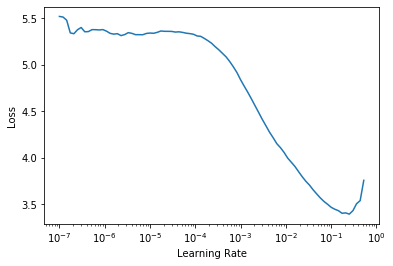

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(5, slice(3e-2))

epoch,train_loss,valid_loss,error_rate,time
0,1.935569,1.548306,0.198917,00:38
1,1.360869,1.022956,0.100135,00:37
2,1.070680,0.958684,0.085250,00:37
3,0.941763,0.930160,0.080514,00:37
4,0.876002,0.905405,0.071719,00:37


In [ ]:
learn.save('stage_1')

Then we can unfreeze it and train a little more

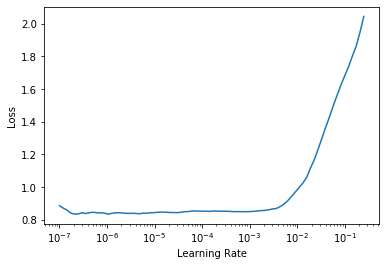

In [ ]:
learn.unfreeze()
learn.lr_find()

In [ ]:
learn.fit_one_cycle(5, 1e-4)

epoch,train_loss,valid_loss,error_rate,time
0,0.856545,0.891247,0.066306,00:50
1,0.835565,0.874920,0.054804,00:50
2,0.801183,0.863947,0.051421,00:50
3,0.779860,0.863559,0.056157,00:50
4,0.772397,0.860884,0.052774,00:50


In [ ]:
learn.save('model_2')

One of the hardest parts about training the `EfficientNet` models is figuring out how to find the right learning rate that won't break everything, so choose cautiously and always a bit lower than what you may want to use after unfreezing

We barely under-matched our Resnet34, **but** we're using a model that is **57%** the size of the Resnet34!

## Pretrained PKL File

Let's say we have a different situation:

* No "pretrained=True"
* Have downloaded weights

* Possible scenarios:
  * Experimenting with a model 
  * Transfer learning twice

How do we do it? Let's take our Cats and Dogs model and train ImageWoof off of it

In [ ]:
path = untar_data(URLs.IMAGEWOOF)
tfms = [[PILImage.create], [parent_label, Categorize()]]
item_tfms = [ToTensor(), Resize(128)]
batch_tfms = [FlipItem(), RandomResizedCrop(128, min_scale=0.35),
              IntToFloatTensor(), Normalize.from_stats(*imagenet_stats)]

In [ ]:
items = get_image_files(path)
split_idx = GrandparentSplitter(valid_name='val')(items)
dsets = Datasets(items, tfms, splits=split_idx)
dls = dsets.dataloaders(after_item=item_tfms, after_batch=batch_tfms, bs=64)

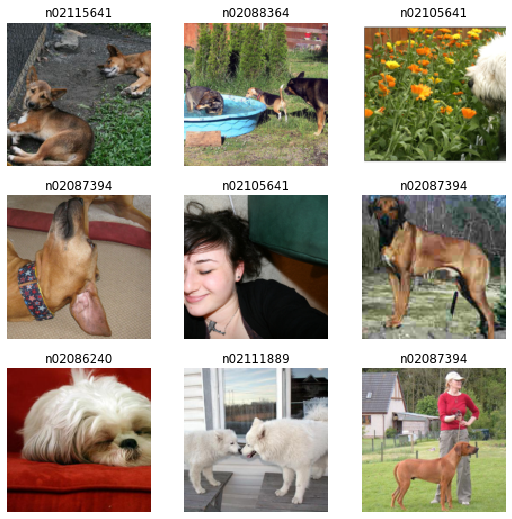

In [ ]:
dls.show_batch()

Let's walk through how we would do that. First let's grab our model and make our `Learner` like we did before, with **everything** but the pretraining!

In [ ]:
body = create_timm_body('efficientnet_b3a', pretrained=False)
head = create_head(1536, dls.c)
model = nn.Sequential(body, head)
apply_init(model[1], nn.init.kaiming_normal_)

In [ ]:
learn = Learner(dls, model, loss_func=LabelSmoothingCrossEntropy(), 
                splitter=default_split, metrics=accuracy)

Now, remember these are all random weights right now. How do we change this? We look at the `state_dict`

In [ ]:
learn.model.state_dict()

The state dict tells us the parameters and weights at **every** layer. Now to work with it, we'll borrow some code from [viraat](https://forums.fast.ai/t/loading-pretrained-weights-that-are-not-from-imagenet/28821/3). Basically what we want to do is:
1. Keep two state_dict's, one of our new model and one of the old
2. If a layer matches, copy the weights
3. Move until there are no more layers
4. Finally load the new state_dict generated

In [ ]:
learn.model_dir

'models'

In [ ]:
def transfer_learn(learn:Learner, name:Path, device:torch.device=None):
    "Load model `name` from `self.model_dir` using `device`, defaulting to `self.dls.device`."
    if device is None: device = learn.dls.device
    learn.model_dir = Path(learn.model_dir)
    if (learn.model_dir/name).with_suffix('.pth').exists(): model_path = (learn.model_dir/name).with_suffix('.pth')
    else: model_path = name
    new_state_dict = torch.load(model_path, map_location=device)['model']
    learn_state_dict = learn.model.state_dict()
    for name, param in learn_state_dict.items():
        if name in new_state_dict:
            input_param = new_state_dict[name]
            if input_param.shape == param.shape:
                param.copy_(input_param)
            else:
                print('Shape mismatch at:', name, 'skipping')
        else:
            print(f'{name} weight of the model not in pretrained weights')
    learn.model.load_state_dict(learn_state_dict)
    return learn

Now let's load some in!

In [ ]:
learn = transfer_learn(learn, 'stage_1')

Shape mismatch at: 1.8.weight skipping


In [ ]:
learn.model[1][8]

Linear(in_features=512, out_features=10, bias=False)

And we can see the only weight that wasn't loaded in was our new layer! Let's freeze and train our model

In [ ]:
learn.freeze()

Let's see if it worked. We'll do a comparison test, 5 epochs without our `transfer_learn` and five with

In [ ]:
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.282371,0.934233,0.832018,00:37
1,0.912630,0.814222,0.883685,00:38
2,0.811893,0.780937,0.893357,00:38
3,0.759423,0.770062,0.896920,00:38
4,0.730576,0.767888,0.898193,00:39


And now let's try on a regular non-transfered learner (at the same learning rate, frozen, etc)

In [ ]:
body = create_timm_body('efficientnet_b3a', pretrained=False)
head = create_head(1536, dls.c)
model = nn.Sequential(body, head)
apply_init(model[1], nn.init.kaiming_normal_)
learn = Learner(dls, model, loss_func=LabelSmoothingCrossEntropy(), 
                splitter=default_split, metrics=accuracy)
learn.freeze()
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,2.869522,2.830859,0.114024,00:38
1,2.684337,2.571606,0.124714,00:38
2,2.543600,2.666231,0.135912,00:38
3,2.485797,2.387705,0.146602,00:38
4,2.430820,2.360096,0.154238,00:38
